[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/parallelization.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239934-lesson-1-parallelization)

英文原版：https://github.com/langchain-ai/langchain-academy/tree/main

译者：Bryce Wang, brycewang2018@gmail.com

# Parallel node execution 并行节点执行

## Review 回顾

在 module 3，我们深入了解了 `human-in-the loop`，展示了3种常见的使用案例：

（1） `Approval` - 我们可以介入我们的 agent，向用户展示 state，并允许用户来接受某个 action。
（2） `Debugging` - 我们可以回溯 graph 来复现或避免问题。
（3）`Editing` - 我们可以修改 state


## Goals 目标

本模块将在第 2 模块中讨论过的 `human-in-the-loop` 和 `memory` 概念的基础上进行扩展。

我们将深入探讨 `multi-agent` 工作流程，并逐步构建一个能够整合本课程所有模块的多智能体研究助手。

为了构建这个多智能体研究助手，我们将首先讨论一些与 LangGraph 可控性相关的主题。


我们从这里开始进入 [parallelization](https://langchain-ai.github.io/langgraph/how-tos/branching/#how-to-create-branches-for-parallel-node-execution).

## Fan out and fan in

让我们构建一个简单的线性图，在每一步都覆盖（over-write）state。

In [ ]:
%%capture --no-stderr
## 让安装库时的大量下载信息不显示，但一旦出错，报错信息仍会显示出来
## 环境准备

## # 安装或升级所需的库
%pip install -U  langgraph tavily-python wikipedia langchain_openai langchain_community langgraph_sdk

## 方便用户输入 API Key
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

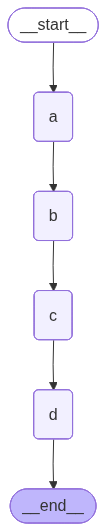

In [3]:
# 导入用于在 Jupyter Notebook 中显示图片的工具
from IPython.display import Image, display

# 类型提示相关模块
from typing import Any
from typing_extensions import TypedDict

# 从 langgraph 引入核心类和常量
from langgraph.graph import StateGraph, START, END

# 定义状态（state）的数据结构
class State(TypedDict):
    # state 是一个字符串，使用 reducer的方式来存储
    # 这里是 append-only，也就是只能追加
    state: str

# 定义一个“节点行为”类，每个节点都会返回自己的值
class ReturnNodeValue:
    def __init__(self, node_secret: str):
        # 保存节点自己的秘密值（node_secret）
        self._value = node_secret

    # 当节点被调用时会执行这个方法
    def __call__(self, state: State) -> Any:
        # 打印当前操作（帮助调试）
        print(f"Adding {self._value} to {state['state']}")
        # 返回一个新的状态字典，把当前节点的值追加进去
        return {"state": [self._value]}

# ---------- 构建图 ----------
# 创建一个状态图对象，指定使用 State 类型
builder = StateGraph(State)

# 添加节点，每个节点对应一个 ReturnNodeValue 实例
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# ---------- 定义流程 ----------
# 设置节点之间的执行顺序（类似有向边）
builder.add_edge(START, "a")  # 从开始到 a
builder.add_edge("a", "b")    # a -> b
builder.add_edge("b", "c")    # b -> c
builder.add_edge("c", "d")    # c -> d
builder.add_edge("d", END)    # 最后 d -> 结束

# 编译整个图，得到可执行的工作流
graph = builder.compile()

# ---------- 可视化 ----------
# 使用 Mermaid 语法画出图，并以图片形式显示
display(Image(graph.get_graph().draw_mermaid_png()))


We over-write state, as expected.

In [ ]:
## graph.invoke(...)：调用已经编译好的 LangGraph 工作流。
## {"state": []}：给它传入初始状态，这里是一个空列表。

graph.invoke({"state": []})

## 因为 ReturnNodeValue 每次都覆盖掉 state，所以最后只保留 "I'm D"

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm B"]
Adding I'm D to ["I'm C"]


{'state': ["I'm D"]}

现在，让我们并行运行 `b` 和 `c`。

然后再运行 `d`。

我们可以很容易地通过从 `a` fan-out 到 `b` 和 `c`，然后再 fan-in 到 `d` 来实现。

状态更新会在每一步结束时被应用。

让我们运行一下。


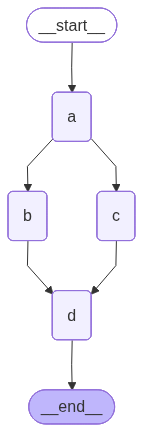

In [4]:
## 现在，让我们并行运行 `b` 和 `c`。
builder = StateGraph(State)

## 初始化各个节点
## 每个节点都会返回一个字符串（自己的标识）
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

## 定义流程
## 从开始节点进入 a
builder.add_edge(START, "a")

## 从 a 分支 (fan-out) 出两条路径，分别到 b 和 c
builder.add_edge("a", "b")
builder.add_edge("a", "c")

## b 和 c 都会在完成后汇合 (fan-in) 到 d
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)

## 编译得到可运行的图
graph = builder.compile()

## 可视化图结构，显示节点和连线关系
display(Image(graph.get_graph().draw_mermaid_png()))

**这里会报错**! 

这是因为 `b` 和 `c` 在同一个步骤，同时写入相同的 key / channel。

In [5]:
# 从 langgraph 中导入错误类型，用于捕获非法的状态更新
from langgraph.errors import InvalidUpdateError

try:
    # 运行图，并传入初始状态（空列表）
    graph.invoke({"state": []})
except InvalidUpdateError as e:
    # 如果运行过程中发生非法状态更新，就会抛出这个错误
    print(f"An error occurred: {e}")

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
An error occurred: At key 'state': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


在使用 fan out 时，如果多个步骤写入相同的 channel / key，我们需要确保使用了 reducer。

正如我们在第 2 模块中提到的，`operator.add` 是 Python 内置 operator 模块中的一个函数。

当 `operator.add` 应用于列表时，它会执行列表拼接操作。

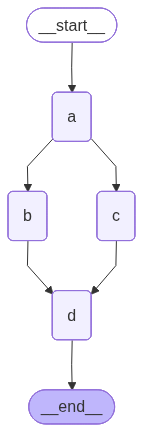

In [6]:
import operator
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# ---------- 定义状态 ----------
class State(TypedDict):
    # 这里定义了一个状态字段 state
    # Annotated[list, operator.add] 的意思是：
    #   - state 是一个 list 类型
    #   - 多个节点同时更新 state 时，使用 operator.add 来合并
    #     （operator.add(list1, list2) 等价于 list1 + list2，也就是拼接）
    # 这样可以避免并行更新时发生冲突（否则会抛出 InvalidUpdateError）
    state: Annotated[list, operator.add]


# ---------- 构建图 ----------
# 创建一个状态图对象，指定使用上面定义的 State 作为状态结构
builder = StateGraph(State)


# ---------- 添加节点 ----------
# 每个节点都会返回一个值，并写入 state
# ReturnNodeValue("I'm X") 会在被调用时返回 {"state": ["I'm X"]}
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))


# ---------- 定义流程 ----------
# 设置节点之间的连接关系（类似画有向图）

builder.add_edge(START, "a")   # 流程从 START 开始，进入 a

# 从 a 分支 (fan-out) 出两条路径：一条到 b，一条到 c
builder.add_edge("a", "b")
builder.add_edge("a", "c")

# b 和 c 都会在完成后汇合 (fan-in) 到 d
builder.add_edge("b", "d")
builder.add_edge("c", "d")

# 最后 d → END，流程结束
builder.add_edge("d", END)


# ---------- 编译并生成图 ----------
# 编译得到一个可执行的工作流对象
graph = builder.compile()

# 使用 Mermaid 语法画出图，并以图片显示流程
display(Image(graph.get_graph().draw_mermaid_png()))


In [7]:
## 运行图，传入初始状态（空列表）
graph.invoke({"state": []})

## 关键的是 "I'm B", "I'm C" 通过 operator.add 被合并到 state 里了

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm D to ["I'm A", "I'm B", "I'm C"]


{'state': ["I'm A", "I'm B", "I'm C", "I'm D"]}

这里我们可以看到，节点 `b` and `c` 的更新被并行地合并到 state 里面。

## 等待节点完成

现在，让我们考虑这样一种情况：一条并行路径的步骤比另一条更多。

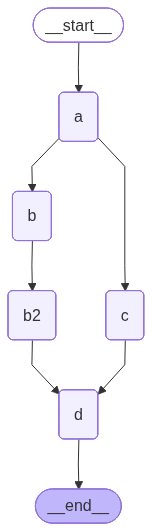

In [8]:
# 定义一个有状态的图（StateGraph），传入状态类型 State
builder = StateGraph(State)

# 添加节点（node）：每个节点代表一个步骤或状态
# ReturnNodeValue("...") 表示这个节点会返回对应的字符串
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("b2", ReturnNodeValue("I'm B2"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# 添加流程（edge）：定义节点之间的连接顺序

# 开始节点 → a
builder.add_edge(START, "a")

# a → b
builder.add_edge("a", "b")

# a → c
builder.add_edge("a", "c")

# b → b2
builder.add_edge("b", "b2")

# b2 和 c 两个路径都要到 d
builder.add_edge(["b2", "c"], "d")

# d → 结束节点
builder.add_edge("d", END)

# 编译生成完整的图
graph = builder.compile()

# 可视化：绘制流程图（Mermaid 格式，显示为图片）
display(Image(graph.get_graph().draw_mermaid_png()))

在这种情况下，`b`、`b2` 和 `c` 都属于同一个步骤。

图会等待它们全部完成之后，才会进入步骤 `d`。


In [9]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm B2 to ["I'm A", "I'm B", "I'm C"]
Adding I'm D to ["I'm A", "I'm B", "I'm C", "I'm B2"]


{'state': ["I'm A", "I'm B", "I'm C", "I'm B2", "I'm D"]}

## 设置状态更新的顺序

然而，在每个步骤内部，我们并不能具体控制状态更新的顺序！

简单来说，这是由 LangGraph 根据图的拓扑结构决定的一个确定性顺序，**而不是我们能控制的**。

在上面的例子中，我们看到 `c` 会在 `b2` 之前被添加。

不过，我们可以通过自定义 reducer 来调整，比如对状态更新进行排序 (sort state updates)。


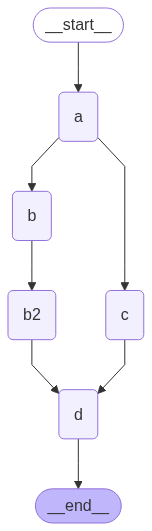

In [ ]:
# 定义一个 reducer（合并器），用于控制 state 的更新顺序
def sorting_reducer(left, right):
    """ 合并并排序列表中的值 """
    # 如果 left 不是列表，就把它变成列表
    if not isinstance(left, list):
        left = [left]

    # 如果 right 不是列表，就把它变成列表
    if not isinstance(right, list):
        right = [right]
    
    # 合并两个列表并排序（reverse=False 表示升序）
    return sorted(left + right, reverse=False)


# 定义 State 类型
class State(TypedDict):
    # 这里使用 sorting_reducer 来保证 state 中的值是排序的
    state: Annotated[list, sorting_reducer]


# 创建一个有状态的图
builder = StateGraph(State)

# 添加节点（每个节点都会返回一个固定的字符串）
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("b2", ReturnNodeValue("I'm B2"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# 定义节点之间的流程
builder.add_edge(START, "a")   # 开始 → a
builder.add_edge("a", "b")     # a → b
builder.add_edge("a", "c")     # a → c
builder.add_edge("b", "b2")    # b → b2
builder.add_edge(["b2", "c"], "d")  # b2 和 c → d
builder.add_edge("d", END)     # d → 结束

# 编译图
graph = builder.compile()

# 可视化流程图
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
## 运行图，传入初始状态（空列表）
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm B2 to ["I'm A", "I'm B", "I'm C"]
Adding I'm D to ["I'm A", "I'm B", "I'm B2", "I'm C"]


{'state': ["I'm A", "I'm B", "I'm B2", "I'm C", "I'm D"]}

现在，reducer 会对更新后的状态值进行排序！

`sorting_reducer` 示例会对所有的值进行全局排序。我们还可以：

1. 在并行步骤中，将输出写入状态中的一个单独字段
2. 在并行步骤之后，使用一个 “sink” 节点来合并并排序这些输出
3. 合并完成后，清理掉临时字段

更多详情请参考 [文档](https://langchain-ai.github.io/langgraph/how-tos/branching/#stable-sorting)。

## 使用大语言模型（LLMs）

现在，让我们添加一个真实的示例！

我们希望从两个外部来源（维基百科和网页搜索）收集上下文，然后让一个大语言模型来回答问题。

In [ ]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0) 


class State(TypedDict):
    question: str
    answer: str
    context: Annotated[list, operator.add]

你可以尝试不同的网页搜索工具。[Tavily](https://tavily.com/) 是一个不错的选择，但请确保已经设置好你的 `TAVILY_API_KEY`。

In [15]:
import os, getpass
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")
_set_env("TAVILY_API_KEY")

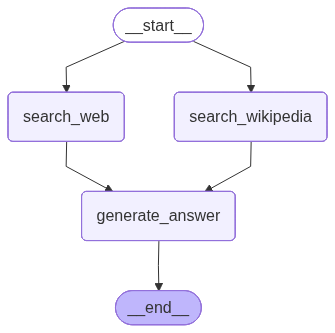

In [11]:
## HumanMessage, 表示用户输入的消息，就像对话中的人类说的话。
## SystemMessage, 表示系统提示或指令，用来告诉模型应该遵循什么规则或背景。
from langchain_core.messages import HumanMessage, SystemMessage
## 这里就是先用 SystemMessage 给模型一个上下文和指令，再用 HumanMessage 明确告诉模型：“请回答问题”


from langchain_community.document_loaders import WikipediaLoader
from langchain_community.tools import TavilySearchResults


def search_web(state):
    """ 从网页搜索中获取文档 """

    # 使用 Tavily 搜索工具，限制返回 3 条结果
    tavily_search = TavilySearchResults(max_results=3)
    # 根据 state 中的问题进行搜索
    search_docs = tavily_search.invoke(state['question'])

    # 格式化搜索结果：把每个结果包装成 <Document> 标签
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}">\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    # 将搜索结果放入 state 中的 context 字段返回
    return {"context": [formatted_search_docs]} 


def search_wikipedia(state):
    """ 从维基百科获取文档 """

    # 使用 WikipediaLoader 搜索，最多加载 2 条结果
    search_docs = WikipediaLoader(query=state['question'], 
                                  load_max_docs=2).load()

    # 格式化搜索结果：包含来源和页面信息
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}">\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    # 将搜索结果放入 state 的 context 中返回
    return {"context": [formatted_search_docs]} 


def generate_answer(state):
    """ 节点：根据上下文回答问题 """

    # 从 state 中获取上下文和问题
    context = state["context"]
    question = state["question"]

    # 构造提示模板
    answer_template = """Answer the question {question} using this context: {context}"""
    answer_instructions = answer_template.format(question=question, 
                                                 context=context)    
    
    # 调用 LLM：传入系统消息（指令）+ 用户消息（要求回答）
    answer = llm.invoke([
        SystemMessage(content=answer_instructions),
        HumanMessage(content="Answer the question.")
    ])
      
    # 将答案添加到 state 中返回
    return {"answer": answer}


# 添加节点（每个节点是一个功能步骤）
builder = StateGraph(State)

builder.add_node("search_web", search_web)          # 节点：网页搜索
builder.add_node("search_wikipedia", search_wikipedia)  # 节点：维基百科搜索
builder.add_node("generate_answer", generate_answer)    # 节点：生成答案

# 定义流程（边）
builder.add_edge(START, "search_wikipedia")   # 开始 → 维基百科搜索
builder.add_edge(START, "search_web")         # 开始 → 网页搜索
builder.add_edge("search_wikipedia", "generate_answer") # 维基百科搜索 → 生成答案
builder.add_edge("search_web", "generate_answer")       # 网页搜索 → 生成答案
builder.add_edge("generate_answer", END)      # 生成答案 → 结束

# 编译图
graph = builder.compile()

# 可视化流程图
display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
result = graph.invoke({"question": "How were Nvidia's Q2 2024 earnings"})
result['answer'].content

/var/folders/jz/2tg__xkj7fq6_dzmcc85dlvh0000gn/T/ipykernel_5990/3921850799.py:11: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_search = TavilySearchResults(max_results=3)


"Nvidia's Q2 2024 earnings were strong, showcasing record revenue and a robust performance in its data center division. The company reported revenue of $30.0 billion, which was up 15% from the previous quarter and up 122% from a year ago. GAAP earnings per diluted share were $0.67, up 12% from the previous quarter and up 168% from a year ago, while non-GAAP earnings per diluted share were $0.68, up 11% from the previous quarter and up 152% from a year ago. Despite a slight dip in gross margin from 78% in Q1 to 75% in Q2, Nvidia remains a dominant force in the AI chip sector. Additionally, Nvidia returned $15.4 billion to shareholders through share repurchases and cash dividends and approved an additional $50.0 billion in share repurchase authorization."

In [ ]:
## END